# Description

Use bid-ask data to analyze and simulate trading execution quality.

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import core.statistics as costatis
import dataflow.core as dtfcore
import dataflow.pipelines.execution.execution_pipeline as dtfpexexpi
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import oms.broker.ccxt.ccxt_aggregation_functions as obccagfu
import oms.broker.ccxt.ccxt_execution_quality as obccexqu
import oms.broker.ccxt.ccxt_logger as obcccclo

/app/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-1f48eec6-b420-4b61-895c-61fad4e00cfa.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.13.0' != container_version='1.12.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmampTask7411_Switch_use_historical_to_data_source_in_Master_bid_ask_execution_analysis_notebook'
  hash='4ce3d175a'
  # Last commits:
    * 4ce3d175a Samarth KaPatel update (#7414)                                                    (  25 hours ago) Fri Mar 1 16:02:48 2024  (HEAD -> CmampTask7411_Switch_use_historical_to_data_source_in_Master_bid_ask_execution_analysis_notebook, origin/master, origin/HEAD, origin/CmampTask

# Config

In [3]:
# When running manually, specify the path to the config to load config from file,
# for e.g., `.../reconciliation_notebook/fast/result_0/config.pkl`.
config_file_name = None
config = cconfig.get_notebook_config(config_file_name)
if config is None:
    system_log_dir = "/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.manual/process_forecasts"
    # Use "logged_during_experiment" to use data logged from inside broker during the experiment.
    # (In full system run might result in gaps in data if no trades were generated for one or more bars).
    bid_ask_data_source = "logged_during_experiment"
    bar_duration = "3T"
    test_asset_id = 1464553467
    config_dict = {
        "meta": {"bid_ask_data_source": bid_ask_data_source},
        "universe": {"test_asset_id": test_asset_id},
        "execution_parameters": {"bar_duration": bar_duration},
        "system_log_dir": system_log_dir,
    }
    config = cconfig.Config.from_dict(config_dict)
print(config)

meta: 
  bid_ask_data_source: logged_during_experiment
universe: 
  test_asset_id: 1464553467
execution_parameters: 
  bar_duration: 3T
system_log_dir: /shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.manual/process_forecasts


In [4]:
system_log_dir = config["system_log_dir"]
bar_duration = config.get_and_mark_as_used(
    ("execution_parameters", "bar_duration")
)
test_asset_id = config.get_and_mark_as_used(("universe", "test_asset_id"))
id_col = "asset_id"
# TODO(Sonaal): This should become an attribute for order.
child_order_execution_freq = "1T"
resample_freq = "100ms"

In [5]:
ccxt_log_reader = obcccclo.CcxtLogger(system_log_dir)
data = ccxt_log_reader.load_all_data(
    convert_to_dataframe=True, abort_on_missing_data=False
)

WARNING Path '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.manual/process_forecasts/args.json' doesn't exist!
WARNING Path '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.manual/process_forecasts/balances' doesn't exist!
WARNING Path '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.manual/process_forecasts/reduce_only/ccxt_child_order_responses' doesn't exist!
WARNING Path '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.manual/process_forecasts/reduce_only/oms_child_orders' doesn't exist!
WARNING Missing required data for 'args': continuing as per user request


Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.…

Loading files from '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/syst…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.…

WARNING Missing required data for 'balances': continuing as per user request
WARNING Missing required data for 'reduce_only_order_responses': continuing as per user request


In [6]:
ccxt_log_reader._bid_ask_full_dir

'/shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.manual/process_forecasts/bid_ask_full'

In [7]:
# Print the Broker config.
if "broker_config" in data:
    print(hprint.to_pretty_str(data["broker_config"]))
else:
    _LOG.warning("broker_config file not present in %s", system_log_dir)

{'bid_ask_lookback': '60S',
 'child_order_quantity_computer': {'object_type': 'DynamicSchedulingChildOrderQuantityComputer'},
 'limit_price_computer': {'_volatility_multiple': [1.5,
                                                   0.7,
                                                   0.7,
                                                   0.6,
                                                   0.6,
                                                   0.5,
                                                   0.5,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                          

In [8]:
# Print the used Config, if any.
experiment_config = obcccclo.load_config_for_execution_analysis(system_log_dir)
print(experiment_config)

INFO  Loading config from /shared_data/ecs/test/system_reconciliation/C12a/prod/20240226_103300.20240226_113000/system_log_dir.manual/system_config.output.values_as_strings.pkl
dag_config: ('False', 'None', "generate_features: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    features: [('p1', [0.11406, 0.561195, 0.697379, 0.64538, -0.38615]), ('p2', [-0.835831, -0.48463, 0.160771, 1.045835, -0.82349])]
    bar_normalization_method: time
combine_features: 
  in_col_groups: [('p1',), ('p2',)]
  out_col_group: ()
  transformer_kwargs: 
    weights: [('p1', 3.4621), ('p2', 7.95919)]
compute_vol: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',)]
  out_col_group: ()
  transformer_kwargs: 
    estimators: ['close', 'garman_klass']
    open_col: open
    high_col: high
    low_col: low
    close_col: close
    apply_log: True
    take_square_root: False
resample: 
  in_col_groups: [('close',), ('high',), ('l

         9872743573: 'binance::NEAR_USDT'}>, 'bar_duration_in_secs': 180, 'rt_timeout_in_secs_or_time': 3600} <dict>, _dst_dir=None <NoneType>, _fit_at_beginning=False <bool>, _wake_up_timestamp=2024-02-26 05:32:00-05:00 <pandas._libs.tslibs.timestamps.Timestamp>, _bar_duration_in_secs=180 <int>, _set_current_bar_timestamp=True <bool>, _max_distance_in_secs=30 <int>, _events=[] <list>)")


In [9]:
# Colums containing price data for analysis.
active_cols = ["buy_limit_order_price", "buy_trade_price"]

# Load data

## Load CCXT data

In [10]:
ccxt_order_response_df = data["ccxt_order_responses"]
ccxt_executed_trades_df = data["ccxt_trades"]

In [11]:
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '8389765655781421512', 'symbol': '...",8389765655781421512,x-xcKtGhcu1fdd1e242f33f6ecfcaa40,1708943586014,2024-02-26T10:33:06.014Z,NaN,1708943586014,ETH/USDT:USDT,limit,GTC,False,False,buy,3063.76,None,0.294,0.0,NaN,0.0,0.294,open,None,[],[],None,None,None,1708943586014,2024-02-26 10:33:06.014000+00:00
1,"{'orderId': '8389765655781431315', 'symbol': '...",8389765655781431315,x-xcKtGhcu5e460550a777422ca14ab7,1708943590281,2024-02-26T10:33:10.281Z,NaN,1708943590281,ETH/USDT:USDT,limit,GTC,False,False,buy,3064.47,None,0.294,0.0,NaN,0.0,0.294,open,None,[],[],None,None,None,1708943590281,2024-02-26 10:33:10.281000+00:00
2,"{'orderId': '8389765655781460445', 'symbol': '...",8389765655781460445,x-xcKtGhcub8fa86389d96508b687273,1708943600237,2024-02-26T10:33:20.237Z,NaN,1708943600237,ETH/USDT:USDT,limit,GTC,False,False,buy,3065.22,None,0.294,0.0,NaN,0.0,0.294,open,None,[],[],None,None,None,1708943600237,2024-02-26 10:33:20.237000+00:00


In [12]:
ccxt_executed_trades_df.head(3)

,timestamp,datetime,symbol,asset_id,id,order,side,takerOrMaker,price,amount,cost,transaction_cost,fees_currency,realized_pnl,first_timestamp,last_timestamp,first_datetime,last_datetime,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-26 10:34:03.827000+00:00,2024-02-26 10:34:03.827000+00:00,2024-02-26 10:34:03.827000+00:00,BTC/USDT:USDT,1467591036,4631022422,272687523812,buy,maker,51256.60,0.012,615.07920,0.123016,USDT,0.0000,2024-02-26 10:34:03.827000+00:00,2024-02-26 10:34:03.827000+00:00,2024-02-26 10:34:03.827000+00:00,2024-02-26 10:34:03.827000+00:00,1,0,0,1,0.012,0.000,0.000,0.012,615.07920,0.0000,0.0000,615.07920
2024-02-26 10:34:03.850000+00:00,2024-02-26 10:34:03.850000+00:00,2024-02-26 10:34:03.850000+00:00,ETH/USDT:USDT,1464553467,3660122523,8389765655781592053,buy,maker,3067.34,0.294,901.79796,0.180360,USDT,0.0000,2024-02-26 10:34:03.850000+00:00,2024-02-26 10:34:03.850000+00:00,2024-02-26 10:34:03.850000+00:00,2024-02-26 10:34:03.850000+00:00,1,0,0,1,0.294,0.000,0.000,0.294,901.79796,0.0000,0.0000,901.79796
2024-02-26 10:36:04.889000+00:00,2024-02-26 10:36:04.889000+00:00,2024-02-26 10:36:04.889000+00:00,BTC/USDT:USDT,1467591036,4631025891,272688676444,sell,taker,51224.30,0.024,1229.38320,0.614692,USDT,-0.3876,2024-02-26 10:36:04.889000+00:00,2024-02-26 10:36:04.889000+00:00,2024-02-26 10:36:04.889000+00:00,2024-02-26 10:36:04.889000+00:00,0,1,1,0,0.000,0.024,0.024,0.000,0.00000,1229.3832,1229.3832,0.00000


In [13]:
oms_child_order_df = data["oms_child_orders"]

In [14]:
oms_child_order_df.iloc[oms_child_order_df["latest_bid_price"].argmax()][
    "extra_params"
]["stats"]

{'_submit_twap_child_order::wave_id': 7,
 '_submit_twap_child_order::get_open_positions.done': Timestamp('2024-02-26 05:55:09.898211-0500', tz='America/New_York'),
 '_submit_twap_child_order::bid_ask_market_data.start': Timestamp('2024-02-26 05:55:09.899427-0500', tz='America/New_York'),
 '_submit_twap_child_order::bid_ask_market_data.done': Timestamp('2024-02-26 05:55:10.152997-0500', tz='America/New_York'),
 '_submit_twap_child_order::child_order.created': Timestamp('2024-02-26 05:55:10.164944-0500', tz='America/New_York'),
 '_submit_twap_child_order::child_order.limit_price_calculated': Timestamp('2024-02-26 05:55:10.171738-0500', tz='America/New_York'),
 '_submit_single_order_to_ccxt::start.timestamp': Timestamp('2024-02-26 05:55:10.173049-0500', tz='America/New_York'),
 '_submit_single_order_to_ccxt::attempt_num': 1,
 '_submit_single_order_to_ccxt::all_attempts_end.timestamp': Timestamp('2024-02-26 05:55:10.185493-0500', tz='America/New_York'),
 '_submit_twap_child_order::child_or

In [ ]:
# Check if `test_asset_id` is present
# If the `test_asset_id` is not present, choose the first traded asset.
traded_asset_ids = sorted(set(oms_child_order_df["asset_id"]))
if test_asset_id not in traded_asset_ids:
    test_asset_id = traded_asset_ids[0]
_LOG.info("test_asset_id=%s", test_asset_id)

## Aggregate CCXT data

In [15]:
# Aggregated executed trades (fills) by bar.
executed_trades_prices = obccagfu.compute_buy_sell_prices_by_bar(
    ccxt_executed_trades_df, bar_duration, groupby_id_col=id_col
)

In [16]:
# Get execution event timestamps by child order.
test_asset_orders = (
    obcccclo.process_child_order_timestamps_and_prices_for_single_asset(
        oms_child_order_df, ccxt_executed_trades_df, test_asset_id, resample_freq
    )
)

In [17]:
test_asset_events = test_asset_orders.sort_index(axis=0)

In [18]:
test_asset_events.head(10)

,event,limit_price,signed_quantity,snapshot_ask_price,snapshot_bid_price
,1464553467,1464553467,1464553467,1464553467,1464553467
timestamp,,,,,
2024-02-26 10:33:04.800000+00:00,knowledge_timestamp,NaN,NaN,3064.71,3064.70
2024-02-26 10:33:05.400000+00:00,_submit_twap_child_order::child_order.limit_pr...,3063.76,0.294,NaN,NaN
2024-02-26 10:33:06.100000+00:00,_submit_twap_child_order::child_order.submitted,NaN,NaN,NaN,NaN
2024-02-26 10:33:09.800000+00:00,knowledge_timestamp,NaN,NaN,3064.88,3064.87
2024-02-26 10:33:10+00:00,end_timestamp,NaN,NaN,NaN,NaN
2024-02-26 10:33:10.300000+00:00,_submit_twap_child_order::child_order.limit_pr...,3064.47,0.294,NaN,NaN
2024-02-26 10:33:10.400000+00:00,_submit_twap_child_order::child_order.submitted,NaN,NaN,NaN,NaN
2024-02-26 10:33:19.800000+00:00,knowledge_timestamp,NaN,NaN,3065.64,3065.63


## Load bid-ask data

In [19]:
def get_data():
    """
    The simulation section of the notebook contains a definition of a DAG with
    a FunctionDataSource source node which requires a function rather than an
    object, so this function returns an object built inside the notebook.
    """
    return bid_ask

In [20]:
# TODO(Paul): Refine the cuts around the first and last bars.
start_timestamp = ccxt_order_response_df["order_update_datetime"].min()
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = ccxt_executed_trades_df["datetime"].max()
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2024-02-26 10:33:05.946000+00:00
INFO  end_timestamp=2024-02-26 11:27:34.089000+00:00


In [21]:
bid_ask, duplicated_rows = obccagfu.load_bid_ask_data(
    start_timestamp,
    end_timestamp,
    ccxt_log_reader,
    config["meta"]["bid_ask_data_source"],
    executed_trades_prices.columns.levels[1],
    child_order_execution_freq,
)

if duplicated_rows is not None:
    display(duplicated_rows)

WARNING Duplicate entry found and dropped:
None
WARNING Duplicated entry that is kept:
None


,currency_pair,exchange_id,end_download_timestamp,knowledge_timestamp,bid_size_l1,bid_price_l1,ask_size_l1,ask_price_l1
timestamp,,,,,,,,
1708943529958,DOGE_USDT,binance,2024-02-26 10:32:10.079448+00:00,2024-02-26 10:32:10.093881+00:00,253379.000,0.08487,240408.000,0.08488
1708943529963,AVAX_USDT,binance,2024-02-26 10:32:10.076852+00:00,2024-02-26 10:32:10.093881+00:00,217.000,36.76500,62.000,36.76600
1708943529964,BNB_USDT,binance,2024-02-26 10:32:10.076977+00:00,2024-02-26 10:32:10.093881+00:00,41.020,388.06000,31.390,388.07000
1708943529977,SAND_USDT,binance,2024-02-26 10:32:10.076258+00:00,2024-02-26 10:32:10.093881+00:00,3606.000,0.52570,2806.000,0.52580
1708943529988,ETH_USDT,binance,2024-02-26 10:32:10.075946+00:00,2024-02-26 10:32:10.093881+00:00,6.177,3065.90000,72.067,3065.91000
...,...,...,...,...,...,...,...,...
1708947159797,AVAX_USDT,binance,2024-02-26 11:32:39.821361+00:00,2024-02-26 11:32:39.838929+00:00,50.000,36.69100,105.000,36.69200
1708947159801,UNFI_USDT,binance,2024-02-26 11:32:39.822468+00:00,2024-02-26 11:32:39.838929+00:00,125.800,7.19700,129.300,7.19800
1708947159802,MATIC_USDT,binance,2024-02-26 11:32:39.821998+00:00,2024-02-26 11:32:39.838929+00:00,7018.000,0.99170,204.000,0.99180


## Load OHLCV data

In [22]:
# We get the end timestamp from ccxt_trades_df which is not the exact time at which the run was completed.
# This created misalignment in the graphs of bid/ask data and OHLCV. Hence we rectify this by re-defining
# end_timestamp based on the bid/ask data.
actual_ohlcv_end_timestamp = bid_ask.index.max().round("min")

In [23]:
ohlcv_bar_duration = bar_duration
db_stage = data["broker_config"]["stage"]
# Get prod `MarketData`.
market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(
    [test_asset_id], db_stage=db_stage
)
# Load and resample OHLCV data.
ohlcv_bars = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    start_timestamp,
    actual_ohlcv_end_timestamp,
    ohlcv_bar_duration,
)
ohlcv_bars.head(3)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/im_v2/devops/env/preprod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: preprod.im_data_db
INFO  Created preprod DB connection: 
 None


/app/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2024-02-26 10:33:05.946000+0000', tz='UTC'), Timestamp('2024-02-26 11:33:00+0000', tz='UTC'))]


,close,high,low,open,twap,volume,vwap
,1464553467,1464553467,1464553467,1464553467,1464553467,1464553467,1464553467
end_timestamp,,,,,,,
2024-02-26 05:36:00-05:00,3062.62,3067.60,3062.32,3064.90,3064.426667,3283.376,3063.987993
2024-02-26 05:39:00-05:00,3065.53,3065.75,3062.62,3062.62,3064.610000,2510.135,3064.570512
2024-02-26 05:42:00-05:00,3067.69,3074.88,3065.17,3065.54,3069.693333,15489.632,3070.953135


In [24]:
ohlcv_price_df = {
    "high": ohlcv_bars["high"],
    "low": ohlcv_bars["low"],
}
ohlcv_price_df = pd.concat(ohlcv_price_df, axis=1)
# Slice data for a test asset id.
test_asset_slice_ohlcv = cofinanc.get_asset_slice(ohlcv_price_df, test_asset_id)
test_asset_slice_ohlcv.head(3)

,high,low
end_timestamp,,
2024-02-26 05:36:00-05:00,3067.60,3062.32
2024-02-26 05:39:00-05:00,3065.75,3062.62
2024-02-26 05:42:00-05:00,3074.88,3065.17


# Plot bid/ask and OHLCV data

In [25]:
bid_ask.head(3)

,bid_price,ask_price,bid_size,ask_size,bid_price,ask_price,bid_size,ask_size
,1467591036,1467591036,1467591036,1467591036,1464553467,1464553467,1464553467,1464553467
timestamp,,,,,,,,
2024-02-26 10:32:05+00:00,51223.0,51223.1,16.822,2.156,3065.4,3065.41,27.188,46.446
2024-02-26 10:32:05.100000+00:00,51223.0,51223.1,16.822,2.156,3065.4,3065.41,27.188,46.446
2024-02-26 10:32:05.200000+00:00,51223.0,51223.1,16.296,2.221,3065.4,3065.41,30.591,65.586


<Axes: xlabel='timestamp'>

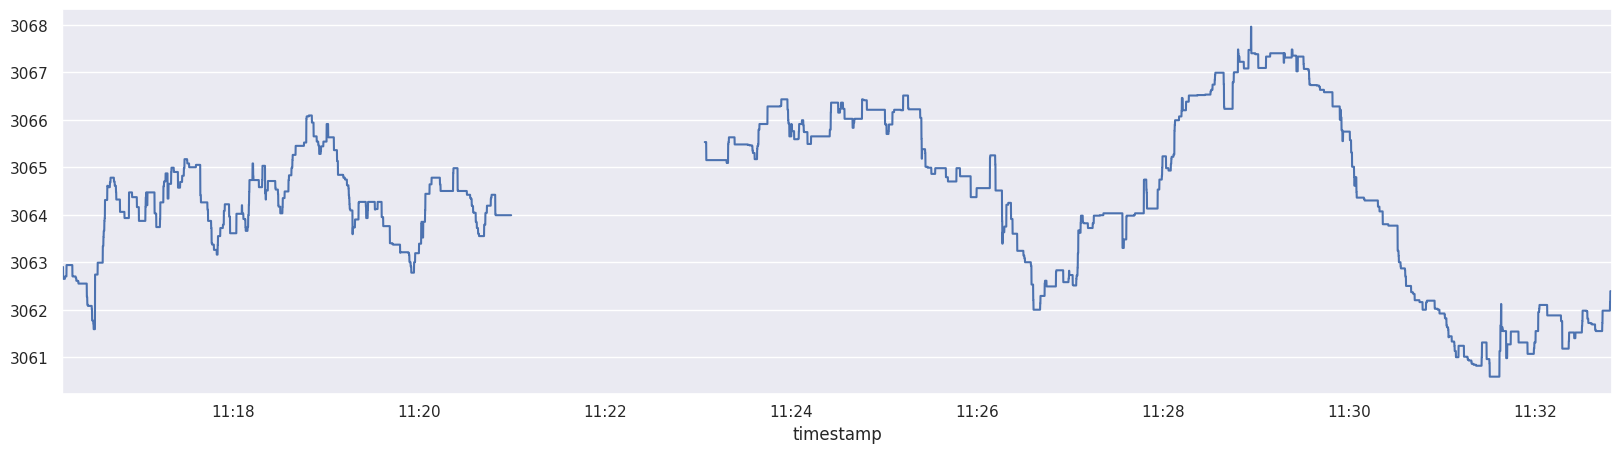

In [26]:
bid_ask["bid_price"][test_asset_id].tail(10000).plot()

In [27]:
test_asset_tob = cofinanc.get_asset_slice(bid_ask, test_asset_id)

<Axes: xlabel='timestamp'>

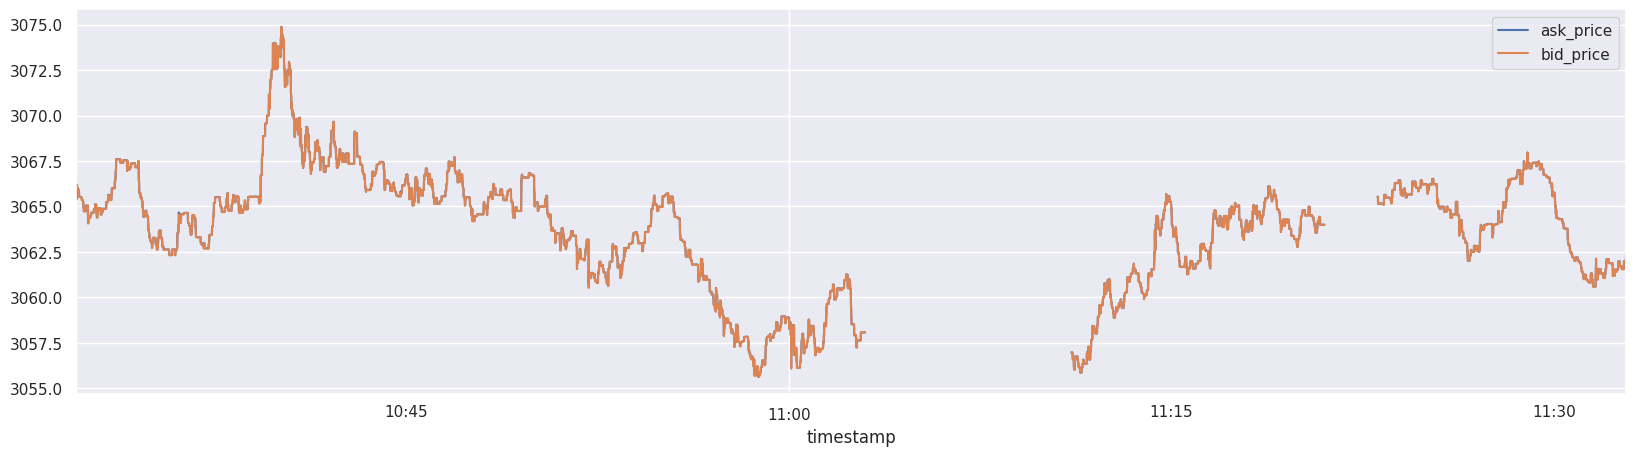

In [28]:
test_asset_tob[["ask_price", "bid_price"]].plot()

<Axes: xlabel='timestamp'>

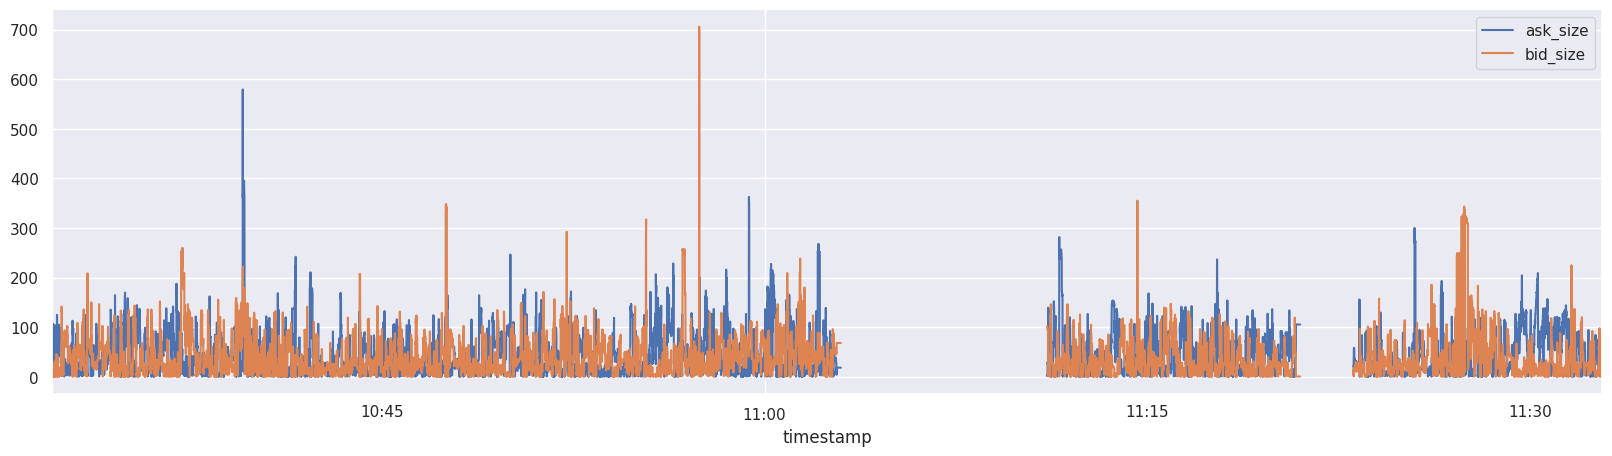

In [29]:
test_asset_tob[["ask_size", "bid_size"]].plot()

<Axes: >

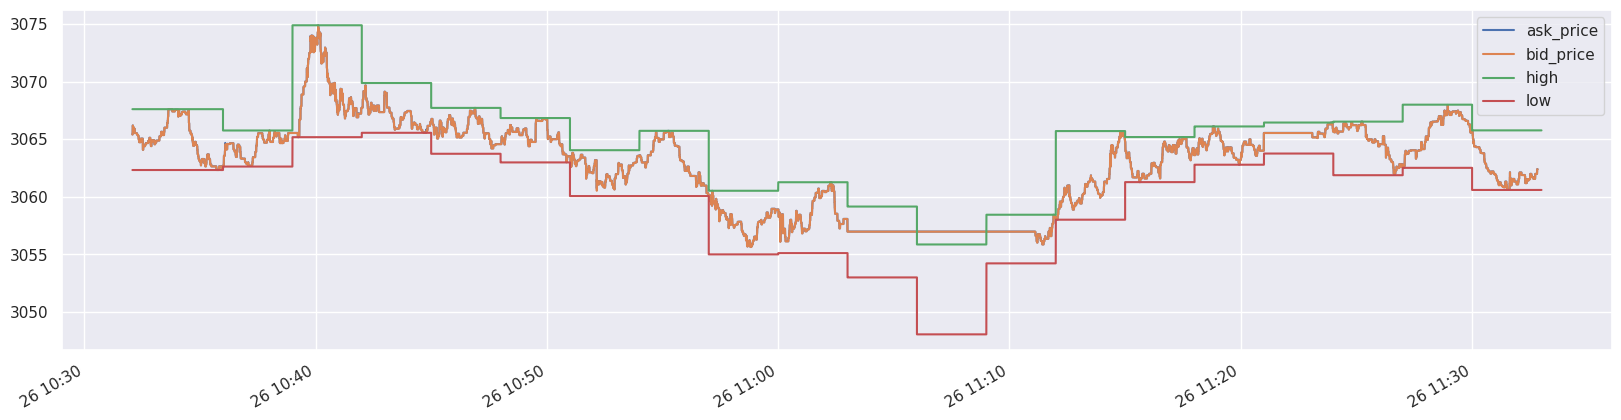

In [30]:
# Plot bid-ask prices together with high and low prices.
test_asset_slice_tob_ohlcv = (
    pd.concat([test_asset_tob, test_asset_slice_ohlcv]).sort_index().bfill()
)
#
test_asset_slice_tob_ohlcv[["ask_price", "bid_price", "high", "low"]].plot()

In [31]:
pd.merge(
    cofinanc.get_asset_slice(
        test_asset_events, test_asset_id, strictly_increasing=False
    ),
    test_asset_tob,
    left_index=True,
    right_index=True,
    how="inner",
).dropna(subset=["event"])

,event,limit_price,signed_quantity,snapshot_ask_price,snapshot_bid_price,bid_price,ask_price,bid_size,ask_size
timestamp,,,,,,,,,
2024-02-26 10:33:04.800000+00:00,knowledge_timestamp,NaN,NaN,3064.71,3064.7,3064.70,3064.71,94.701,6.300
2024-02-26 10:33:05.400000+00:00,_submit_twap_child_order::child_order.limit_pr...,3063.76,0.294,NaN,NaN,3064.70,3064.71,38.336,29.029
2024-02-26 10:33:06.100000+00:00,_submit_twap_child_order::child_order.submitted,NaN,NaN,NaN,NaN,3064.70,3064.71,40.387,15.592
2024-02-26 10:33:09.800000+00:00,knowledge_timestamp,NaN,NaN,3064.88,3064.87,3064.87,3064.88,62.579,5.197
2024-02-26 10:33:10+00:00,end_timestamp,NaN,NaN,NaN,NaN,3064.87,3064.88,62.352,4.651
2024-02-26 10:33:10.300000+00:00,_submit_twap_child_order::child_order.limit_pr...,3064.47,0.294,NaN,NaN,3064.87,3064.88,62.419,4.553
2024-02-26 10:33:10.400000+00:00,_submit_twap_child_order::child_order.submitted,NaN,NaN,NaN,NaN,3064.87,3064.88,62.419,4.553
2024-02-26 10:33:19.800000+00:00,knowledge_timestamp,NaN,NaN,3065.64,3065.63,3065.63,3065.64,14.060,35.607
2024-02-26 10:33:20+00:00,end_timestamp,NaN,NaN,NaN,NaN,3065.63,3065.64,36.073,5.437


# Replay limit orders and simulate trades

- Use actual limit prices seen in actual execution
- Simulate execution using actual limit prices and bid-ask data
- Compare simulated execution to actual execution

## Extract the actual limit orders

In [32]:
bid_ask.columns.levels[1]

Index([1464553467, 1467591036], dtype='int64')

In [33]:
oms_child_order_df_restricted = oms_child_order_df[
    oms_child_order_df["asset_id"].isin(bid_ask.columns.levels[1])
]
oms_child_order_df_restricted.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2024-02-26 10:33:05.354272+00:00,1464553467,limit,2024-02-26 10:33:05.354272+00:00,2024-02-26 10:33:10+00:00,0.0,0.294,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,1.5,0,287,2024-02-26 10:33:04.657000+00:00,2024-02-26 10:33:04.776624+00:00,2024-02-26 10:33:04.756358+00:00,100.508,4.315,597,10.0,0.629904,2.055352,3064.70,0.630303,2.056648,3064.71,0.630103,3064.705,2.056000,0.01,0.032630,63.010333,3063.76,8389765655781421512,3,1
5,2024-02-26 10:33:10.262291+00:00,1464553467,limit,2024-02-26 10:33:10.262291+00:00,2024-02-26 10:33:20+00:00,0.0,0.294,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,1,287,2024-02-26 10:33:09.718000+00:00,2024-02-26 10:33:09.798260+00:00,2024-02-26 10:33:09.779963+00:00,62.579,5.197,599,10.0,0.584656,1.907605,3064.87,0.585514,1.910396,3064.88,0.585085,3064.875,1.909001,0.01,0.032628,58.508496,3064.47,8389765655781431315,5,1
7,2024-02-26 10:33:20.216029+00:00,1464553467,limit,2024-02-26 10:33:20.216029+00:00,2024-02-26 10:33:30+00:00,0.0,0.294,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,2,287,2024-02-26 10:33:19.704000+00:00,2024-02-26 10:33:19.785395+00:00,2024-02-26 10:33:19.769062+00:00,14.060,35.607,598,10.0,0.600405,1.958503,3065.63,0.601241,1.961225,3065.64,0.600823,3065.635,1.959865,0.01,0.032620,60.082300,3065.22,8389765655781460445,7,1


In [34]:
# Forward fill to represent the time-in-force of the underlying order.
limit_prices = obccexqu.get_limit_order_price(oms_child_order_df_restricted)
limit_prices.head(3)

buy_limit_order_price            sell_limit_order_price           
asset_id                             1464553467 1467591036             1464553467 1467591036
creation_timestamp                                                                          
2024-02-26 10:33:06+00:00               3063.76    51226.6                    NaN        NaN
2024-02-26 10:33:07+00:00                   NaN        NaN                    NaN        NaN
2024-02-26 10:33:08+00:00                   NaN        NaN                    NaN        NaN

In [35]:
buy_order_num = np.sign(limit_prices["buy_limit_order_price"]).abs().cumsum()
sell_order_num = np.sign(limit_prices["sell_limit_order_price"]).abs().cumsum()

In [36]:
limit_prices = pd.concat(
    {
        "buy_limit_order_price": limit_prices["buy_limit_order_price"],
        "sell_limit_order_price": limit_prices["sell_limit_order_price"],
        "buy_order_num": buy_order_num,
        "sell_order_num": sell_order_num,
    },
    axis=1,
).ffill(limit=59)

## Join limit orders with bid-ask data and simulate trades

In [37]:
in_df = pd.concat([limit_prices, bid_ask], axis=1)
in_df.head(3)

buy_limit_order_price            sell_limit_order_price            buy_order_num            sell_order_num             bid_price  ask_price   bid_size   ask_size  bid_price  ask_price   bid_size   ask_size
                                            1464553467 1467591036             1464553467 1467591036    1464553467 1467591036     1464553467 1467591036 1467591036 1467591036 1467591036 1467591036 1464553467 1464553467 1464553467 1464553467
2024-02-26 10:32:05+00:00                          NaN        NaN                    NaN        NaN           NaN        NaN            NaN        NaN    51223.0    51223.1     16.822      2.156     3065.4    3065.41     27.188     46.446
2024-02-26 10:32:05.100000+00:00                   NaN        NaN                    NaN        NaN           NaN        NaN            NaN        NaN    51223.0    51223.1     16.822      2.156     3065.4    3065.41     27.188     46.446
2024-02-26 10:32:05.200000+00:00                   NaN        NaN                    NaN        NaN           NaN        NaN            NaN        NaN    51223.0    51223.1     16.296      2.221     3065.4    3065.41     30.591     65.586

In [38]:
node = dtfcore.GroupedColDfToDfTransformer(
    "estimate_limit_order_execution",
    transformer_func=cofinanc.estimate_limit_order_execution,
    **{
        "in_col_groups": [
            ("bid_price",),
            ("ask_price",),
            ("buy_limit_order_price",),
            ("sell_limit_order_price",),
            ("buy_order_num",),
            ("sell_order_num",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "bid_col": "bid_price",
            "ask_col": "ask_price",
            "buy_limit_price_col": "buy_limit_order_price",
            "sell_limit_price_col": "sell_limit_order_price",
            "buy_order_num_col": "buy_order_num",
            "sell_order_num_col": "sell_order_num",
        },
    },
)

In [39]:
simulated_execution_df = node.fit(in_df)["df_out"]

/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [40]:
simulated_execution_df.columns.levels[0].to_list()

['ask_price',
 'ask_size',
 'bid_price',
 'bid_size',
 'buy_limit_order_price',
 'buy_order_num',
 'buy_trade_price',
 'limit_buy_executed',
 'limit_sell_executed',
 'sell_limit_order_price',
 'sell_order_num',
 'sell_trade_price']

In [41]:
test_asset_exec = cofinanc.get_asset_slice(simulated_execution_df, test_asset_id)
test_asset_exec.loc[~test_asset_exec["buy_trade_price"].isna()][
    [
        "buy_trade_price",
        "buy_limit_order_price",
        "buy_order_num",
        "bid_price",
        "ask_price",
    ]
]

,buy_trade_price,buy_limit_order_price,buy_order_num,bid_price,ask_price
2024-02-26 10:34:04.100000+00:00,3066.96,NaN,NaN,3066.95,3066.96
2024-02-26 10:45:08.100000+00:00,3065.41,NaN,NaN,3065.4,3065.41
2024-02-26 10:48:23.100000+00:00,3065.41,NaN,NaN,3065.4,3065.41
2024-02-26 11:00:06.100000+00:00,3057.21,NaN,NaN,3057.2,3057.21
2024-02-26 11:24:35.100000+00:00,3066.03,NaN,NaN,3066.02,3066.03
2024-02-26 11:27:34.100000+00:00,3063.31,NaN,NaN,3063.3,3063.31


In [42]:
simulated_execution_df["buy_trade_price"].resample(
    "5T", closed="right", label="right"
).mean()

,1464553467,1467591036
2024-02-26 10:35:00+00:00,3066.96,51253.2
2024-02-26 10:40:00+00:00,NaN,NaN
2024-02-26 10:45:00+00:00,NaN,51250.1
2024-02-26 10:50:00+00:00,3065.41,NaN
2024-02-26 10:55:00+00:00,NaN,51218.8
2024-02-26 11:00:00+00:00,NaN,NaN
2024-02-26 11:05:00+00:00,3057.21,51190.5
2024-02-26 11:10:00+00:00,NaN,NaN
2024-02-26 11:15:00+00:00,NaN,51133.3
2024-02-26 11:20:00+00:00,NaN,NaN


In [43]:
test_asset_slice = cofinanc.get_asset_slice(simulated_execution_df, test_asset_id)

<Axes: >

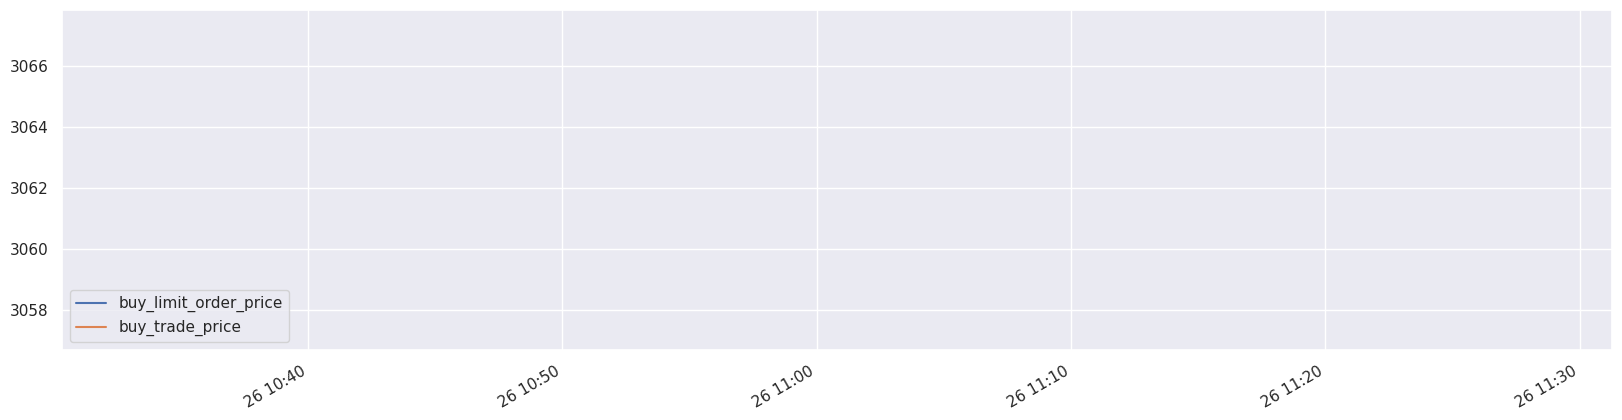

In [44]:
test_asset_slice[active_cols].plot()

<Axes: >

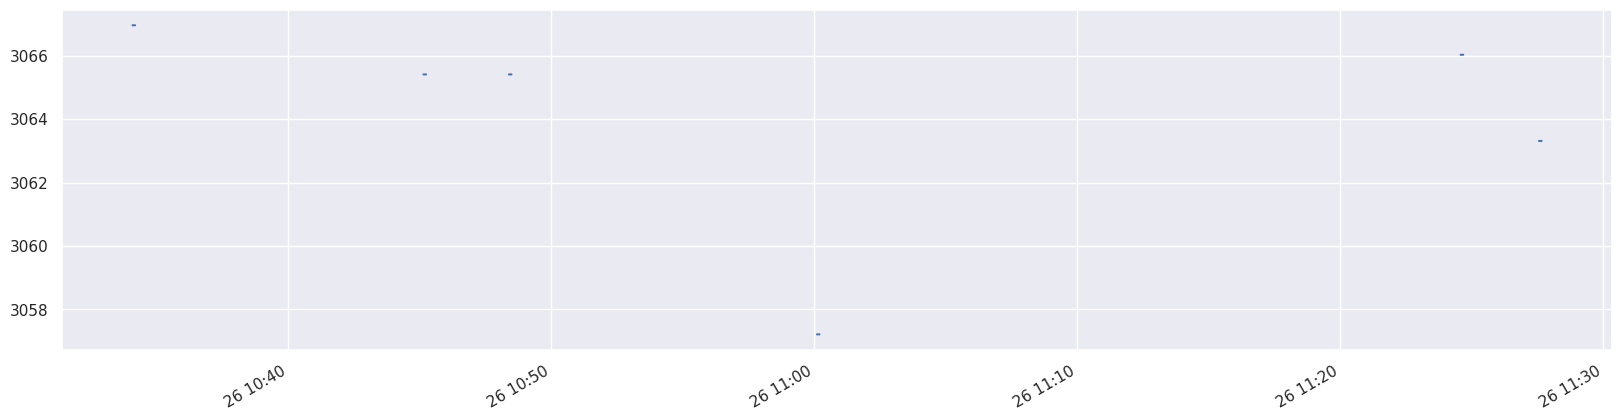

In [45]:
test_asset_slice["buy_trade_price"].ffill(limit=59).plot()

## Compute simulated trade execution quality against bid-ask benchmarks

In [46]:
simulated_execution_quality_node = dtfcore.GroupedColDfToDfTransformer(
    "simulated_execution_quality",
    transformer_func=cofinanc.compute_bid_ask_execution_quality,
    **{
        "in_col_groups": [
            ("buy_trade_price",),
            ("sell_trade_price",),
            ("bid_price",),
            ("ask_price",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "bid_col": "bid_price",
            "ask_col": "ask_price",
            "buy_trade_price_col": "buy_trade_price",
            "sell_trade_price_col": "sell_trade_price",
        },
    },
)

In [47]:
simulated_execution_quality_df = simulated_execution_quality_node.fit(
    simulated_execution_df
)["df_out"]

/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [48]:
simulated_execution_quality_df.columns.levels[0].to_list()

['ask_price',
 'ask_size',
 'bid_ask_midpoint',
 'bid_price',
 'bid_size',
 'buy_limit_order_price',
 'buy_order_num',
 'buy_trade_midpoint_slippage_bps',
 'buy_trade_midpoint_slippage_notional',
 'buy_trade_price',
 'buy_trade_price_improvement_bps',
 'buy_trade_price_improvement_notional',
 'buy_trade_price_improvement_spread_pct',
 'limit_buy_executed',
 'limit_sell_executed',
 'sell_limit_order_price',
 'sell_order_num',
 'sell_trade_midpoint_slippage_bps',
 'sell_trade_midpoint_slippage_notional',
 'sell_trade_price',
 'sell_trade_price_improvement_bps',
 'sell_trade_price_improvement_notional',
 'sell_trade_price_improvement_spread_pct',
 'spread_bps',
 'spread_notional']

In [49]:
test_asset_slice = cofinanc.get_asset_slice(
    simulated_execution_quality_df, test_asset_id
)
test_asset_slice[active_cols].dropna(how="all")

,buy_limit_order_price,buy_trade_price
2024-02-26 10:33:06+00:00,3063.76,NaN
2024-02-26 10:33:07+00:00,3063.76,NaN
2024-02-26 10:33:08+00:00,3063.76,NaN
2024-02-26 10:33:09+00:00,3063.76,NaN
2024-02-26 10:33:10+00:00,3063.76,NaN
2024-02-26 10:33:11+00:00,3064.47,NaN
2024-02-26 10:33:12+00:00,3064.47,NaN
2024-02-26 10:33:13+00:00,3064.47,NaN
2024-02-26 10:33:14+00:00,3064.47,NaN
2024-02-26 10:33:15+00:00,3064.47,NaN


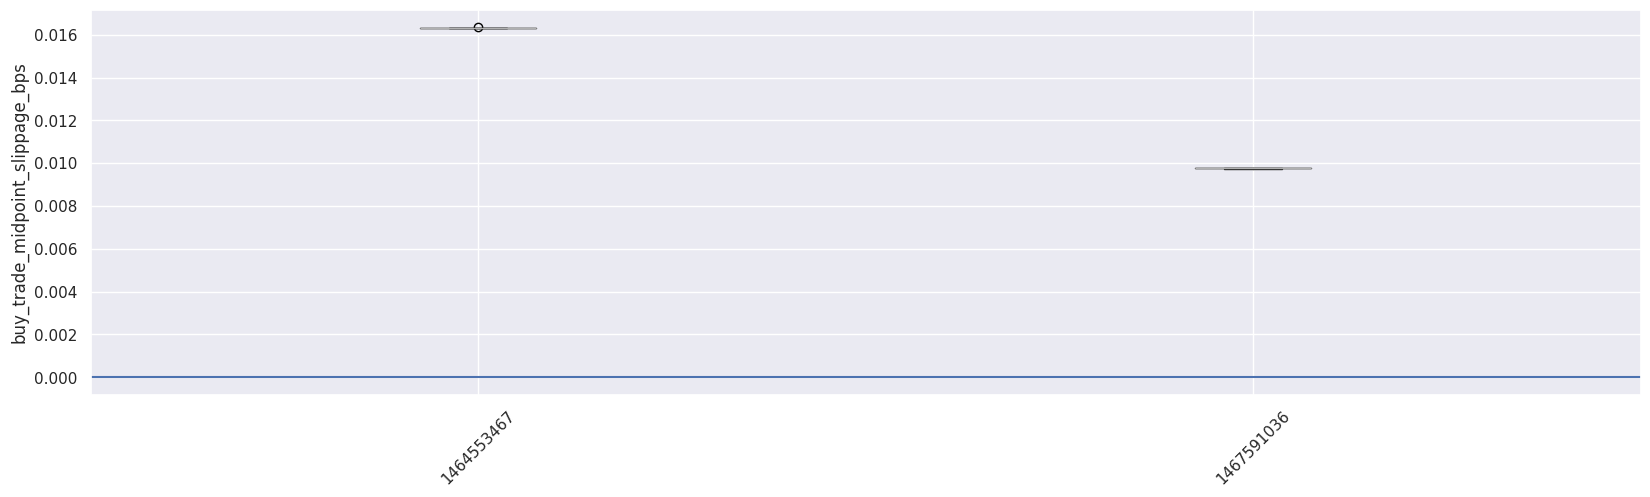

In [50]:
col = "buy_trade_midpoint_slippage_bps"
coplotti.plot_boxplot(simulated_execution_quality_df[col], "by_col", ylabel=col)

<Axes: >

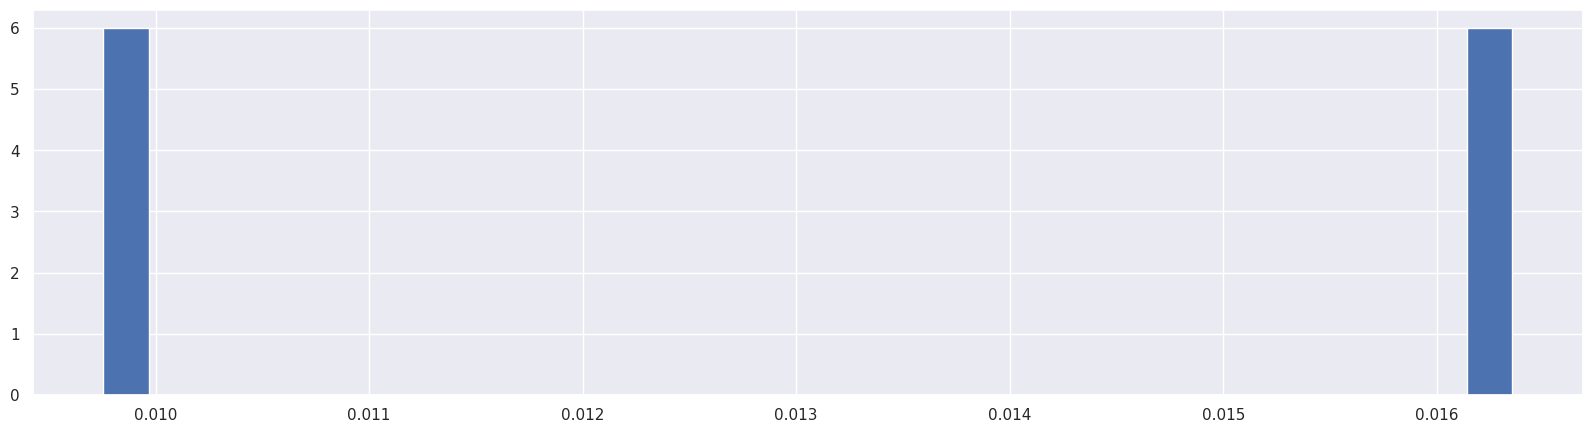

In [51]:
simulated_execution_quality_df["buy_trade_midpoint_slippage_bps"].unstack().hist(
    bins=31
)

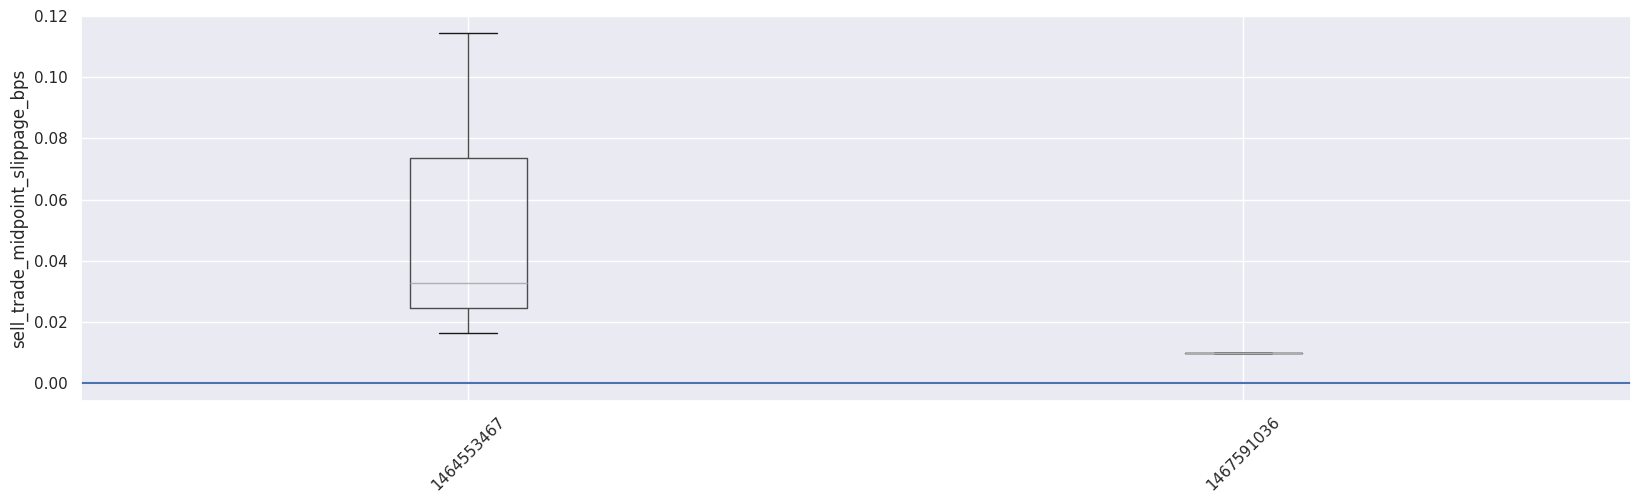

In [52]:
col = "sell_trade_midpoint_slippage_bps"
coplotti.plot_boxplot(simulated_execution_quality_df[col], "by_col", ylabel=col)

<Axes: >

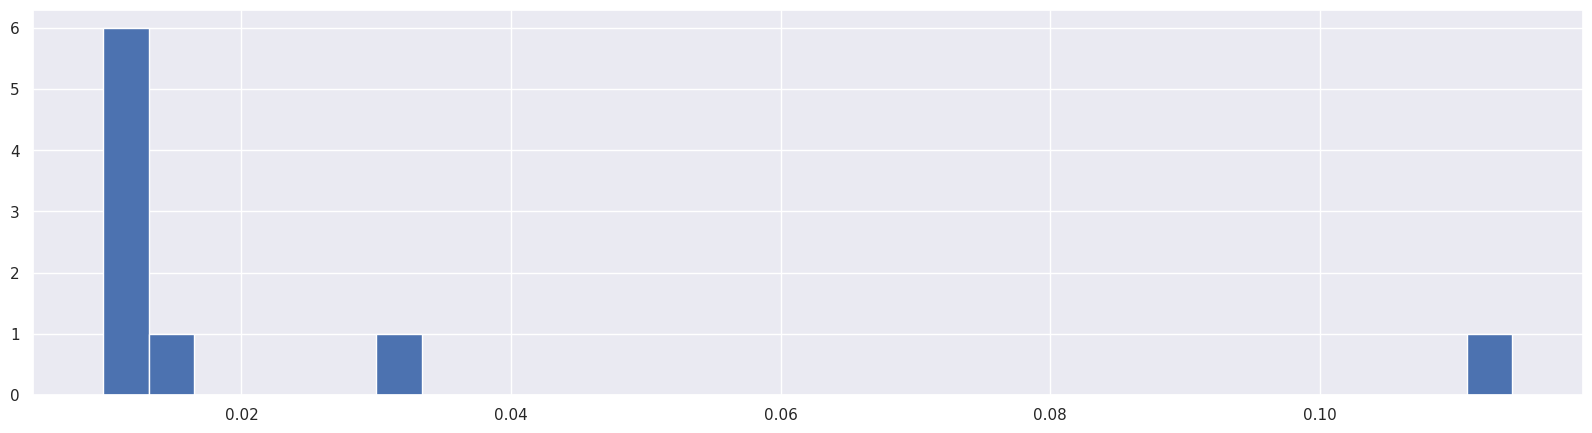

In [53]:
simulated_execution_quality_df["sell_trade_midpoint_slippage_bps"].unstack().hist(
    bins=31
)

In [54]:
costatis.compute_moments(
    simulated_execution_quality_df["buy_trade_midpoint_slippage_bps"].unstack()
)

mean        0.013041
std         0.003423
skew        0.000034
kurtosis   -1.999932
dtype: float64

In [55]:
costatis.compute_moments(simulated_execution_quality_df["spread_bps"].unstack())

mean           0.026671
std            0.022601
skew          56.625639
kurtosis    4109.479356
dtype: float64

## Compare actual trade prices to simulated trade prices

In [56]:
actual_vs_sim_trade_price_resampling_freq = "1T"

In [57]:
# The "8s" is an empirically-derived estimate of order delay.
simulated_execution_df["sell_limit_order_price"].resample(
    actual_vs_sim_trade_price_resampling_freq,
    closed="right",
    label="right",
    offset="8s",
).mean().head(3)

,1464553467,1467591036
2024-02-26 10:32:08+00:00,NaN,NaN
2024-02-26 10:33:08+00:00,NaN,NaN
2024-02-26 10:34:08+00:00,NaN,NaN


In [58]:
executed_trades_prices = obccagfu.compute_buy_sell_prices_by_bar(
    ccxt_executed_trades_df,
    actual_vs_sim_trade_price_resampling_freq,
    offset="8s",
    groupby_id_col="asset_id",
)
executed_trades_prices.head(3)

buy_trade_price            sell_trade_price           
asset_id                       1464553467 1467591036       1464553467 1467591036
bar_end_datetime                                                                
2024-02-26 10:35:08+00:00         3067.34    51256.6              NaN        NaN
2024-02-26 10:37:08+00:00             NaN        NaN              NaN    51224.3
2024-02-26 10:40:08+00:00             NaN        NaN          3065.82        NaN

In [59]:
resampled_simulated_execution_df = simulated_execution_df.resample(
    actual_vs_sim_trade_price_resampling_freq,
    closed="right",
    label="right",
    offset="8s",
).mean()
resampled_simulated_execution_df.head(3)

buy_trade_price            limit_buy_executed            limit_sell_executed            sell_trade_price            buy_limit_order_price            sell_limit_order_price            buy_order_num            sell_order_num                bid_price     ask_price   bid_size   ask_size    bid_price    ask_price   bid_size   ask_size
                               1464553467 1467591036         1464553467 1467591036          1464553467 1467591036       1464553467 1467591036            1464553467 1467591036             1464553467 1467591036    1464553467 1467591036     1464553467 1467591036    1467591036    1467591036 1467591036 1467591036   1464553467   1464553467 1464553467 1464553467
2024-02-26 10:32:08+00:00             NaN        NaN           0.000000   0.000000                 0.0        0.0              NaN        NaN                   NaN        NaN                    NaN        NaN           NaN        NaN            NaN        NaN  51230.451613  51230.551613   9.315161   2.749903  3065.907419  3065.918065  14.685000  74.270258
2024-02-26 10:33:08+00:00             NaN        NaN           0.000000   0.000000                 0.0        0.0              NaN        NaN           3063.760000    51226.6                    NaN        NaN           1.0        1.0            NaN        NaN  51231.647500  51231.749833   6.145817  10.640373  3064.908817  3064.918850  34.504278  42.999855
2024-02-26 10:34:08+00:00         3066.96    51253.2           0.001667   0.001667                 0.0        0.0              NaN        NaN           3066.065667    51243.5                    NaN        NaN           4.3        4.3            NaN        NaN  51246.380500  51246.480500   7.882790   5.305265  3066.510567  3066.520567  48.025183  32.923207

In [60]:
actual_executed_trades_prices = obccagfu.compute_buy_sell_prices_by_bar(
    ccxt_executed_trades_df, "1s", offset="0s", groupby_id_col="asset_id"
)

In [61]:
actual_vs_sim_trade_price_resampling_freq = "5T"

In [62]:
simulated_and_actual_trade_price_df = obccagfu.combine_sim_and_actual_trades(
    simulated_execution_df,
    ccxt_executed_trades_df,
    actual_vs_sim_trade_price_resampling_freq,
    offset="8s",
)
simulated_and_actual_trade_price_df.head(3)

actual_buy_trade_price            actual_sell_trade_price            simulated_buy_trade_price            simulated_sell_trade_price           
                                      1464553467 1467591036              1464553467 1467591036                1464553467 1467591036                 1464553467 1467591036
2024-02-26 10:35:08+00:00                3067.34    51256.6                     NaN        NaN                   3066.96    51253.2                        NaN        NaN
2024-02-26 10:40:08+00:00                    NaN        NaN                 3065.82    51224.3                       NaN        NaN                    3066.56    51224.3
2024-02-26 10:45:08+00:00                    NaN    51250.6                     NaN        NaN                       NaN    51250.1                        NaN        NaN

In [63]:
cofinanc.get_asset_slice(simulated_and_actual_trade_price_df, test_asset_id)[
    ["actual_buy_trade_price", "simulated_buy_trade_price"]
].dropna(how="all")

,actual_buy_trade_price,simulated_buy_trade_price
2024-02-26 10:35:08+00:00,3067.340000,3066.96
2024-02-26 10:50:08+00:00,3065.438333,3065.41
2024-02-26 11:00:08+00:00,NaN,3057.21
2024-02-26 11:05:08+00:00,3057.860000,NaN
2024-02-26 11:25:08+00:00,3066.130000,3066.03
2024-02-26 11:30:08+00:00,3063.770000,3063.31


In [64]:
cofinanc.get_asset_slice(simulated_and_actual_trade_price_df, test_asset_id)[
    ["actual_sell_trade_price", "simulated_sell_trade_price"]
].dropna(how="all")

,actual_sell_trade_price,simulated_sell_trade_price
2024-02-26 10:40:08+00:00,3065.82,3066.56
2024-02-26 11:00:08+00:00,3060.50,NaN
2024-02-26 11:15:08+00:00,3058.95,3059.28
2024-02-26 11:20:08+00:00,3062.08,3062.08


In [65]:
execution_quality_node = dtfcore.GroupedColDfToDfTransformer(
    "execution_quality",
    transformer_func=cofinanc.compute_ref_price_execution_quality,
    **{
        "in_col_groups": [
            ("actual_buy_trade_price",),
            ("actual_sell_trade_price",),
            ("simulated_buy_trade_price",),
            ("simulated_sell_trade_price",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "buy_trade_reference_price_col": "simulated_buy_trade_price",
            "sell_trade_reference_price_col": "simulated_sell_trade_price",
            "buy_trade_price_col": "actual_buy_trade_price",
            "sell_trade_price_col": "actual_sell_trade_price",
        },
    },
)

In [66]:
sim_vs_actual_execution_quality_df = execution_quality_node.fit(
    simulated_and_actual_trade_price_df
)["df_out"]

In [67]:
sim_vs_actual_execution_quality_df.columns.levels[0].to_list()

['actual_buy_trade_price',
 'actual_sell_trade_price',
 'buy_trade_slippage_bps',
 'buy_trade_slippage_notional',
 'sell_trade_slippage_bps',
 'sell_trade_slippage_notional',
 'simulated_buy_trade_price',
 'simulated_sell_trade_price']

In [68]:
cofinanc.get_asset_slice(sim_vs_actual_execution_quality_df, test_asset_id)

,buy_trade_slippage_bps,buy_trade_slippage_notional,sell_trade_slippage_bps,sell_trade_slippage_notional,actual_buy_trade_price,actual_sell_trade_price,simulated_buy_trade_price,simulated_sell_trade_price
2024-02-26 10:35:08+00:00,1.239012,0.380000,NaN,NaN,3067.340000,NaN,3066.96,NaN
2024-02-26 10:40:08+00:00,NaN,NaN,2.413127,0.74,NaN,3065.82,NaN,3066.56
2024-02-26 10:45:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-26 10:50:08+00:00,0.092429,0.028333,NaN,NaN,3065.438333,NaN,3065.41,NaN
2024-02-26 10:55:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-26 11:00:08+00:00,NaN,NaN,NaN,NaN,NaN,3060.50,3057.21,NaN
2024-02-26 11:05:08+00:00,NaN,NaN,NaN,NaN,3057.860000,NaN,NaN,NaN
2024-02-26 11:10:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-26 11:15:08+00:00,NaN,NaN,1.078685,0.33,NaN,3058.95,NaN,3059.28
2024-02-26 11:20:08+00:00,NaN,NaN,0.000000,0.00,NaN,3062.08,NaN,3062.08


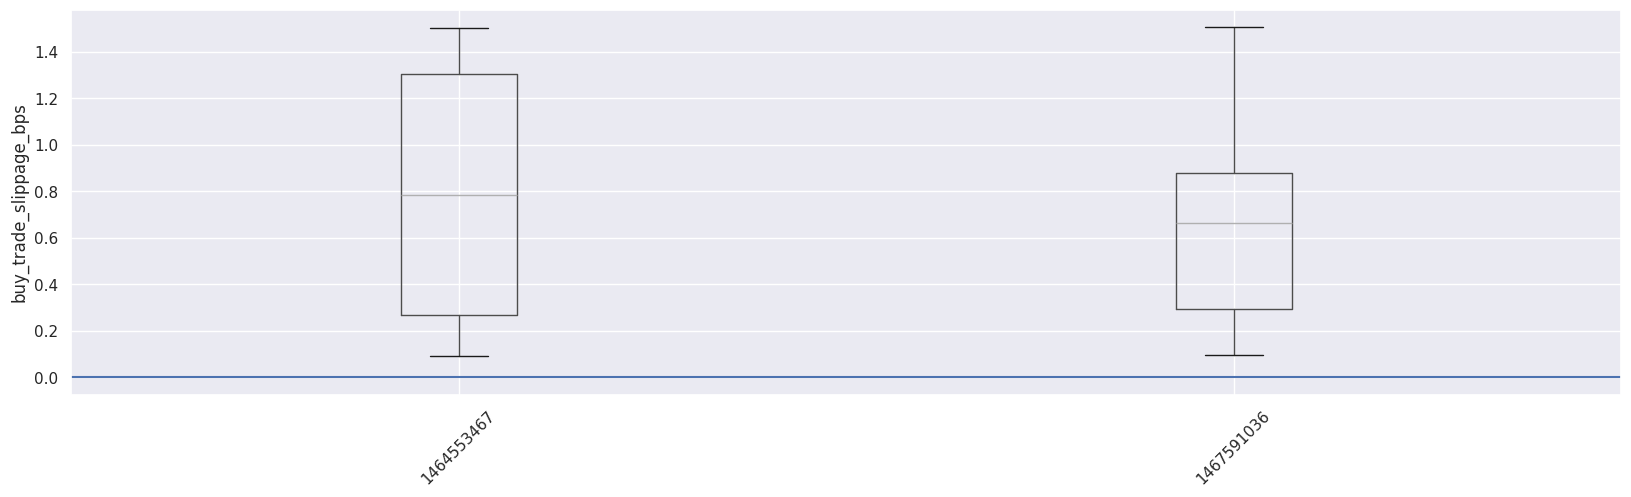

In [69]:
col = "buy_trade_slippage_bps"
coplotti.plot_boxplot(
    sim_vs_actual_execution_quality_df[col], "by_col", ylabel=col
)

<Axes: >

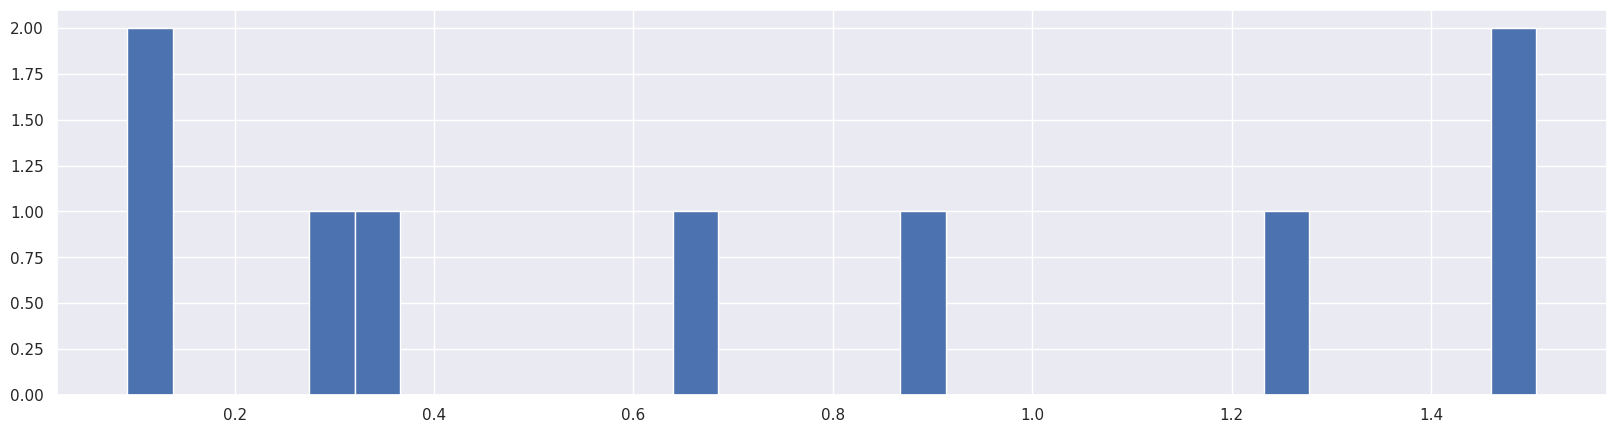

In [70]:
sim_vs_actual_execution_quality_df["buy_trade_slippage_bps"].unstack().hist(
    bins=31
)

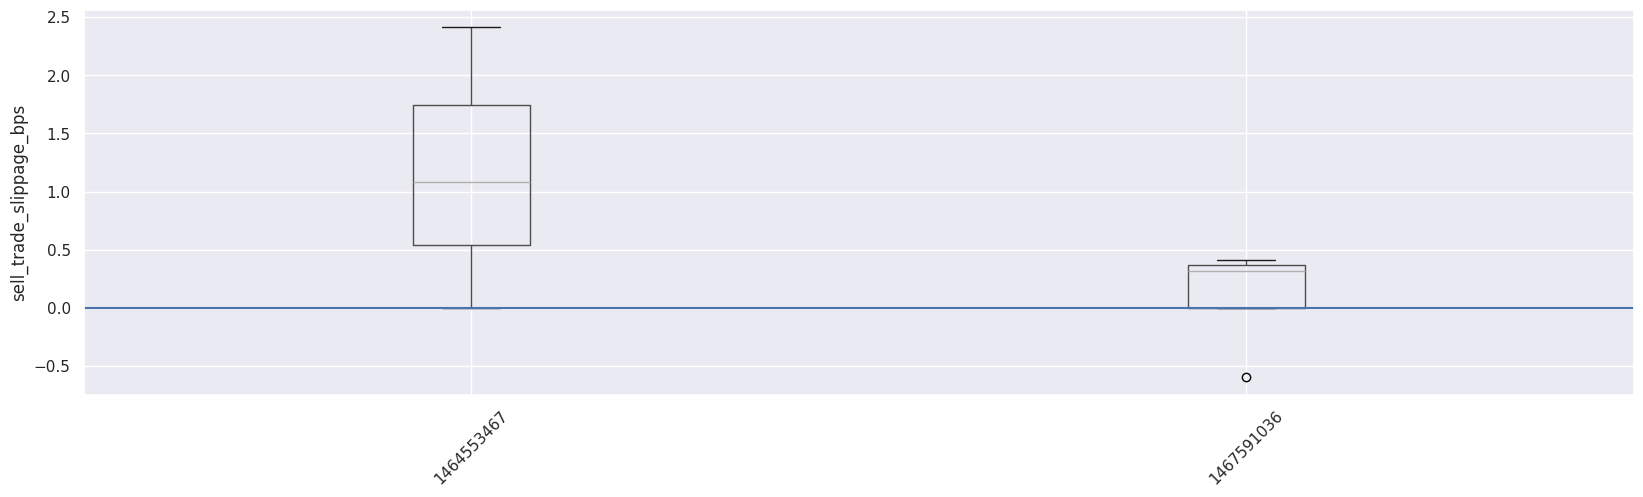

In [71]:
col = "sell_trade_slippage_bps"
coplotti.plot_boxplot(
    sim_vs_actual_execution_quality_df[col], "by_col", ylabel=col
)

<Axes: >

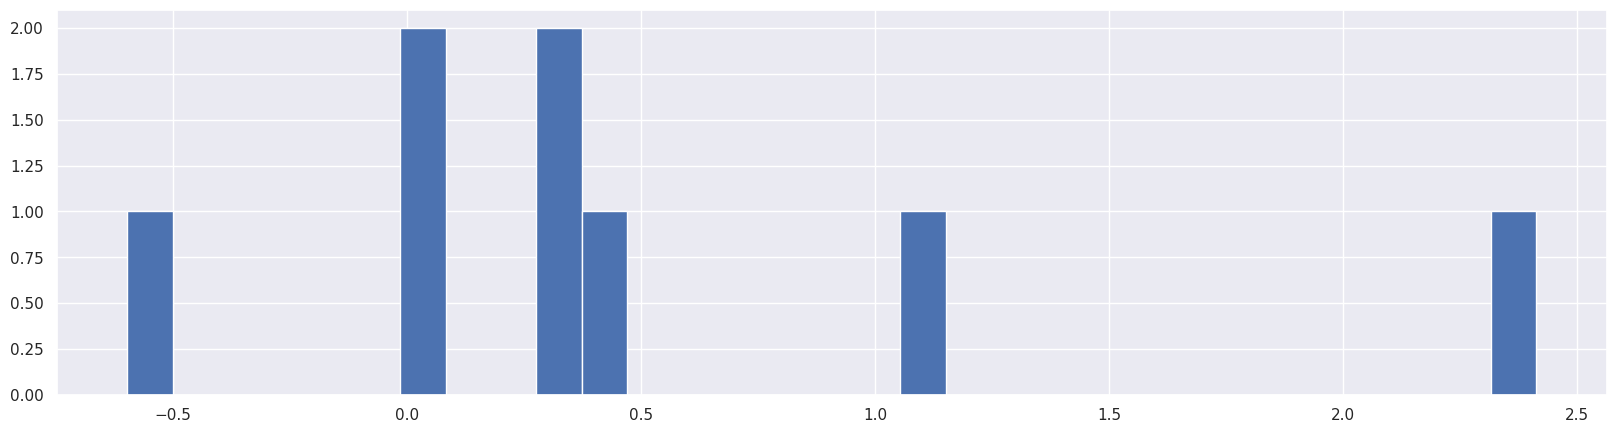

In [72]:
sim_vs_actual_execution_quality_df["sell_trade_slippage_bps"].unstack().hist(
    bins=31
)

# Simulate limit order generation and trades

- Specify buy/sell aggressiveness parameters
- Specify repricing frequency and time-in-force
- Simulate average execution prices and percentage of bars filled

In [73]:
dag_builder = dtfpexexpi.ExecutionPipeline()
#
config = dag_builder.get_config_template()
# Set up `overwrite` mode to allow reassignment of values.
# Note: by default the `update_mode` does not allow overwrites,
# but they are required by the FeaturePipeline.
config.update_mode = "overwrite"
_LOG.debug("config from dag_builder=%s", config)
# Initialize config.
config["load_data"] = cconfig.Config.from_dict(
    {
        "source_node_name": "FunctionDataSource",
        "source_node_kwargs": {
            "func": get_data,
        },
    }
)
config["resample", "transformer_kwargs", "rule"] = "1T"
config["resample", "transformer_kwargs", "resample_kwargs", "offset"] = "8s"
config[
    "generate_limit_orders", "transformer_kwargs", "buy_spread_frac_offset"
] = 0.45
config[
    "generate_limit_orders", "transformer_kwargs", "sell_spread_frac_offset"
] = -0.45
config["generate_limit_orders", "transformer_kwargs", "subsample_freq"] = "60s"
config["generate_limit_orders", "transformer_kwargs", "freq_offset"] = "9s"
config["generate_limit_orders", "transformer_kwargs", "ffill_limit"] = 59

#
_LOG.debug("config after patching=%s", config)
dag = dag_builder.get_dag(config)

In [74]:
bid_ask_sim_flow_df = dag.run_leq_node(
    "compute_trade_vs_limit_execution_quality", "fit"
)["df_out"]

run_leq_node:   0%|          | 0/5 [00:00<?, ?it/s]

/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values
/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values
/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [75]:
bid_ask_sim_flow_df.columns.levels[0].to_list()

['ask_price',
 'bid_ask_midpoint',
 'bid_price',
 'buy_limit_order_price',
 'buy_order_num',
 'buy_trade_limit_slippage_bps',
 'buy_trade_limit_slippage_notional',
 'buy_trade_midpoint_slippage_bps',
 'buy_trade_midpoint_slippage_notional',
 'buy_trade_price',
 'buy_trade_price_improvement_bps',
 'buy_trade_price_improvement_notional',
 'buy_trade_price_improvement_spread_pct',
 'limit_buy_executed',
 'limit_sell_executed',
 'sell_limit_order_price',
 'sell_order_num',
 'sell_trade_limit_slippage_bps',
 'sell_trade_limit_slippage_notional',
 'sell_trade_midpoint_slippage_bps',
 'sell_trade_midpoint_slippage_notional',
 'sell_trade_price',
 'sell_trade_price_improvement_bps',
 'sell_trade_price_improvement_notional',
 'sell_trade_price_improvement_spread_pct',
 'spread_bps',
 'spread_notional']

In [76]:
test_asset_df = cofinanc.get_asset_slice(bid_ask_sim_flow_df, test_asset_id)
test_asset_df[
    [
        "bid_price",
        "ask_price",
        "buy_order_num",
        "buy_trade_price",
        "buy_limit_order_price",
    ]
]

,bid_price,ask_price,buy_order_num,buy_trade_price,buy_limit_order_price
timestamp,,,,,
2024-02-26 10:32:08+00:00,3065.907419,3065.918065,NaN,NaN,NaN
2024-02-26 10:33:08+00:00,3064.908817,3064.918850,1.0,3065.9045,3065.9045
2024-02-26 10:34:08+00:00,3066.510567,3066.520567,2.0,NaN,3064.8745
2024-02-26 10:35:08+00:00,3065.445100,3065.455100,3.0,NaN,3067.0145
2024-02-26 10:36:08+00:00,3062.909100,3062.919600,4.0,3063.2745,3063.2745
2024-02-26 10:37:08+00:00,3063.848167,3063.858167,5.0,NaN,3064.1145
2024-02-26 10:38:08+00:00,3064.487533,3064.497567,6.0,NaN,3062.6945
2024-02-26 10:39:08+00:00,3065.224883,3065.234883,7.0,NaN,3064.7545
2024-02-26 10:40:08+00:00,3070.394717,3070.406850,8.0,3065.5345,3065.5345


In [77]:
bid_ask_sim_flow_df.head(3)

buy_trade_limit_slippage_bps            buy_trade_limit_slippage_notional            sell_trade_limit_slippage_bps            sell_trade_limit_slippage_notional            bid_ask_midpoint               buy_trade_midpoint_slippage_bps            buy_trade_midpoint_slippage_notional            buy_trade_price_improvement_bps            buy_trade_price_improvement_notional            buy_trade_price_improvement_spread_pct            sell_trade_midpoint_slippage_bps            sell_trade_midpoint_slippage_notional            sell_trade_price_improvement_bps            sell_trade_price_improvement_notional            sell_trade_price_improvement_spread_pct            spread_bps            spread_notional               ask_price                  bid_price               buy_limit_order_price            buy_order_num            buy_trade_price            limit_buy_executed            limit_sell_executed            sell_limit_order_price            sell_order_num  \
                                            1464553467 1467591036                        1464553467 1467591036                    1464553467 1467591036                         1464553467 1467591036       1464553467    1467591036                      1464553467 1467591036                           1464553467 1467591036                      1464553467 1467591036                           1464553467 1467591036                             1464553467 1467591036                       1464553467 1467591036                            1464553467 1467591036                       1464553467 1467591036                            1464553467 1467591036                              1464553467 1467591036 1464553467 1467591036      1464553467 1467591036   1464553467    1467591036   1464553467    1467591036            1464553467 1467591036    1464553467 1467591036      1464553467 1467591036         1464553467 1467591036          1464553467 1467591036             1464553467 1467591036     1464553467   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2024-02-26 10:32:08+00:00                          NaN        NaN                               NaN        NaN                           NaN        NaN                                NaN        NaN      3065.912742  51230.501613                             NaN        NaN                                  NaN        NaN                             NaN        NaN                                  NaN        NaN                                    NaN        NaN                              NaN        NaN                                   NaN        NaN                              NaN        NaN                                   NaN        NaN                                     NaN        NaN   0.034721   0.019520        0.010645   0.100000  3065.918065  51230.551613  3065.907419  51230.451613                   NaN        NaN           NaN        NaN             NaN        NaN           0.000000        0.0            0.000000        0.0                    NaN        NaN            NaN   
2024-02-26 10:33:08+00:00     

<Axes: xlabel='timestamp'>

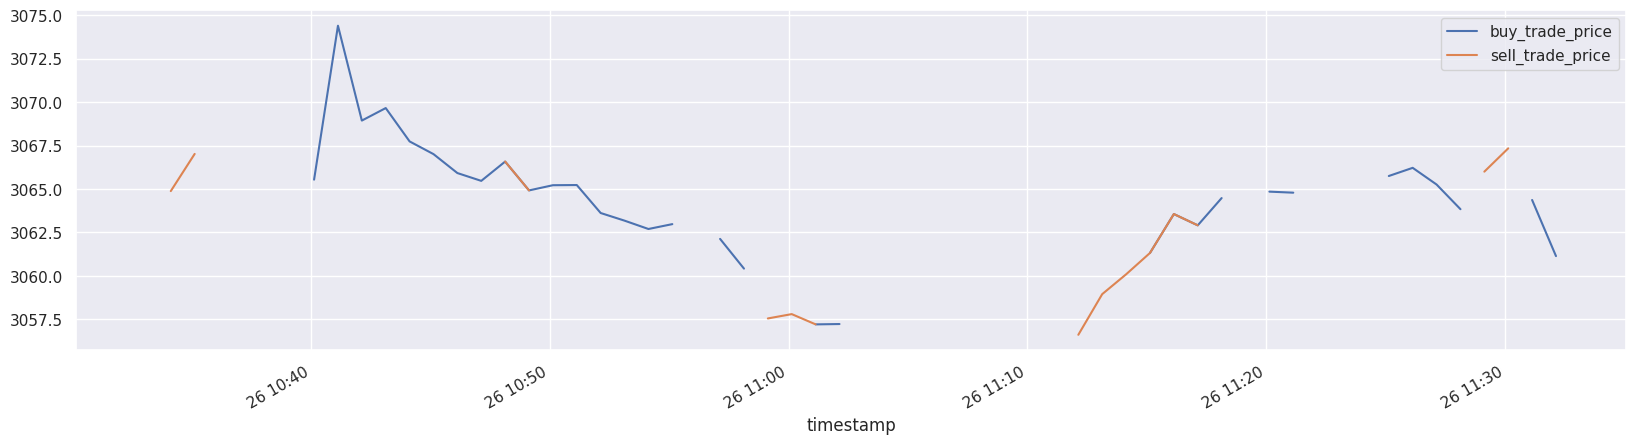

In [78]:
cofinanc.get_asset_slice(bid_ask_sim_flow_df, test_asset_id)[
    ["buy_trade_price", "sell_trade_price"]
].plot()

In [79]:
cofinanc.get_asset_slice(bid_ask_sim_flow_df, test_asset_id).head(3)

,buy_trade_limit_slippage_bps,buy_trade_limit_slippage_notional,sell_trade_limit_slippage_bps,sell_trade_limit_slippage_notional,bid_ask_midpoint,buy_trade_midpoint_slippage_bps,buy_trade_midpoint_slippage_notional,buy_trade_price_improvement_bps,buy_trade_price_improvement_notional,buy_trade_price_improvement_spread_pct,sell_trade_midpoint_slippage_bps,sell_trade_midpoint_slippage_notional,sell_trade_price_improvement_bps,sell_trade_price_improvement_notional,sell_trade_price_improvement_spread_pct,spread_bps,spread_notional,ask_price,bid_price,buy_limit_order_price,buy_order_num,buy_trade_price,limit_buy_executed,limit_sell_executed,sell_limit_order_price,sell_order_num,sell_trade_price
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-26 10:32:08+00:00,NaN,NaN,NaN,NaN,3065.912742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034721,0.010645,3065.918065,3065.907419,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
2024-02-26 10:33:08+00:00,0.0,0.0,NaN,NaN,3064.913833,3.232282,0.990667,-3.215909,-0.98565,-9823.754153,NaN,NaN,NaN,NaN,NaN,0.032736,0.010033,3064.918850,3064.908817,3065.9045,1.0,3065.9045,0.001667,0.000000,3065.9055,1.0,NaN
2024-02-26 10:34:08+00:00,NaN,NaN,0.0,0.0,3066.515567,NaN,NaN,NaN,NaN,NaN,5.348307,1.640067,-5.332011,-1.635067,-16350.666667,0.032610,0.010000,3066.520567,3066.510567,3064.8745,2.0,NaN,0.000000,0.001667,3064.8755,2.0,3064.8755


<Axes: xlabel='timestamp'>

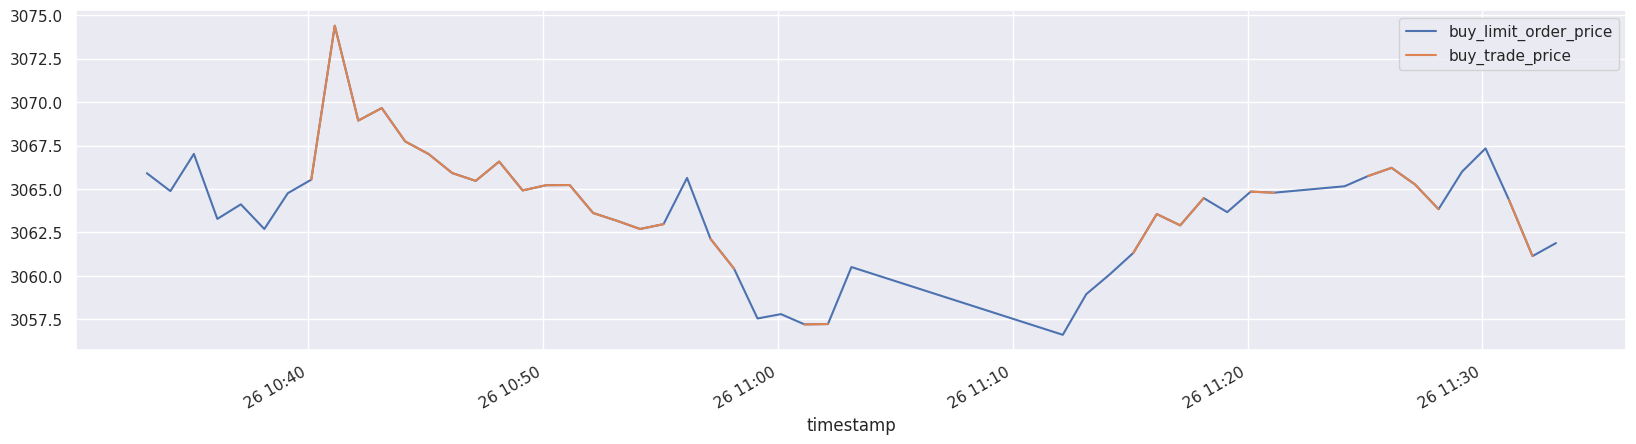

In [80]:
test_asset_simulated_prices = cofinanc.get_asset_slice(
    bid_ask_sim_flow_df, test_asset_id
)
test_asset_simulated_prices[active_cols].dropna(how="all").plot()

In [81]:
costatis.compute_moments(
    bid_ask_sim_flow_df["buy_trade_limit_slippage_bps"].unstack()
)

mean        0.0
std         0.0
skew        NaN
kurtosis    NaN
dtype: float64

In [82]:
costatis.compute_moments(
    bid_ask_sim_flow_df["sell_trade_limit_slippage_bps"].unstack()
)

mean        3.541573e-14
std         2.295202e-13
skew        6.246950e+00
kurtosis    3.702439e+01
dtype: float64

# Compare simulated limit orders and actual limit orders

In [83]:
simulated_buy_limits = bid_ask_sim_flow_df["buy_limit_order_price"]
simulated_buy_limits.head(3)

,1464553467,1467591036
timestamp,,
2024-02-26 10:32:08+00:00,NaN,NaN
2024-02-26 10:33:08+00:00,3065.9045,51232.645
2024-02-26 10:34:08+00:00,3064.8745,51231.045


In [84]:
actual_buy_limits = in_df["buy_limit_order_price"]
actual_buy_limits.head(3)

,1464553467,1467591036
2024-02-26 10:32:05+00:00,NaN,NaN
2024-02-26 10:32:05.100000+00:00,NaN,NaN
2024-02-26 10:32:05.200000+00:00,NaN,NaN


In [85]:
lim_vs_lim = pd.concat(
    {
        "simulated_buy_limit": simulated_buy_limits,
        "actual_buy_limit": actual_buy_limits.resample(
            "1T", offset="8s", closed="right", label="right"
        ).mean(),
    },
    axis=1,
)

In [86]:
lim_vs_lim.columns.levels[1]

Index([1464553467, 1467591036], dtype='int64')

<Axes: >

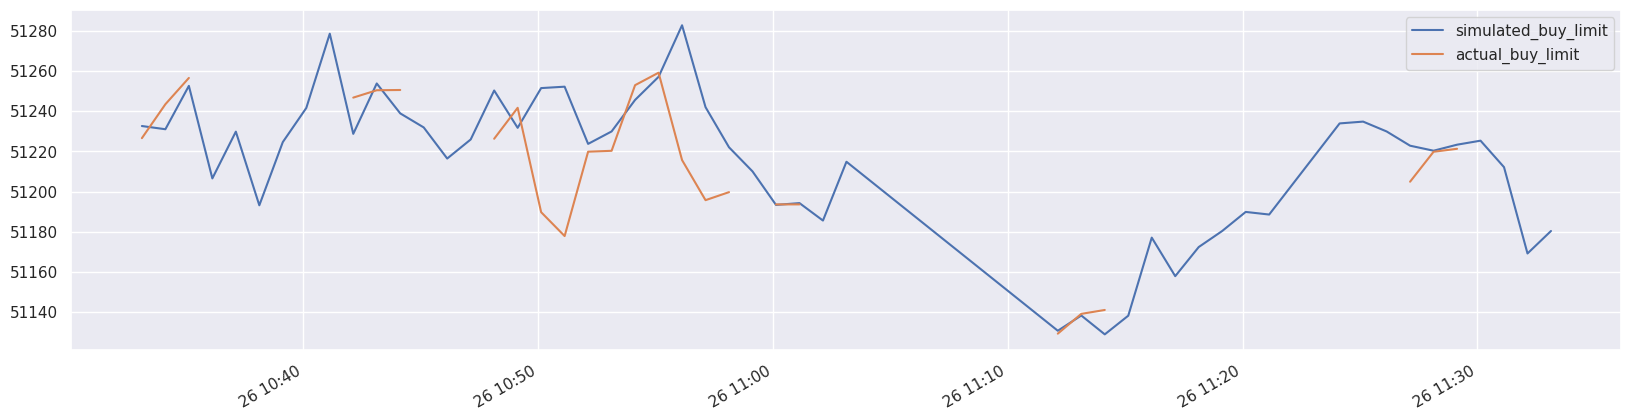

In [87]:
cofinanc.get_asset_slice(lim_vs_lim, lim_vs_lim.columns.levels[1][1]).dropna(
    how="all"
).plot()

<Axes: >

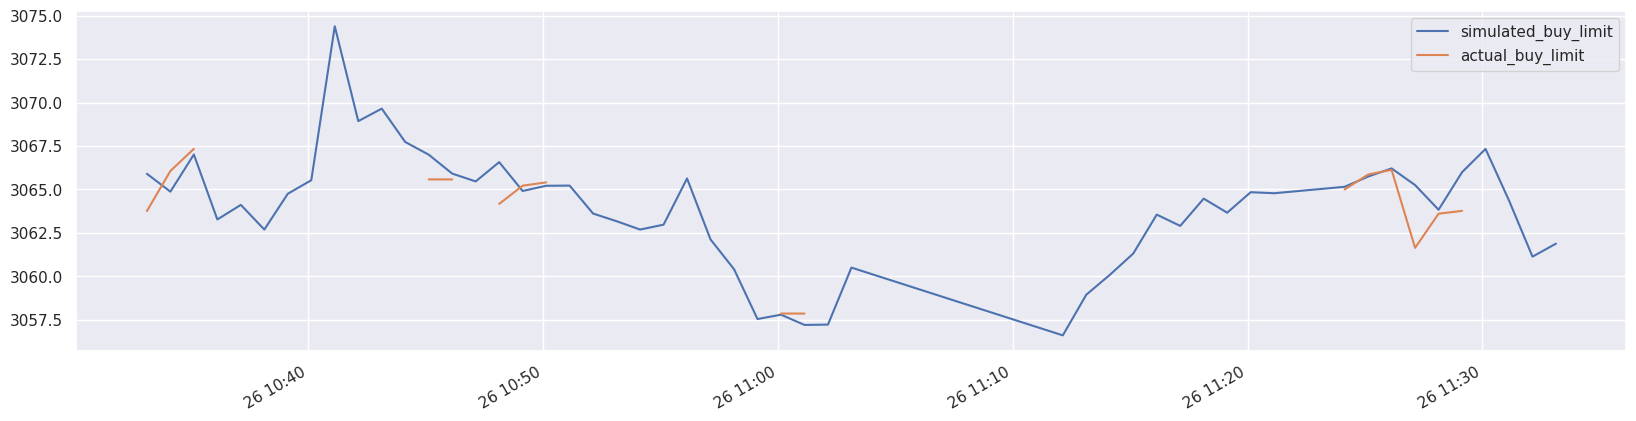

In [88]:
cofinanc.get_asset_slice(lim_vs_lim, lim_vs_lim.columns.levels[1][0]).dropna(
    how="all"
).plot()